# Анализ прибыльности приложения Procrastinate Pro+

Наша задача выяснить почему в последние несколько месяцев компания терпит убытки несмотря на вложения средств в рекламу
В нашем распоряжении есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года 

## Открываем файл с данными и изучите общую информацию

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

# Загрузим данные
try:
    visits = pd.read_csv ('/datasets/visits_info_short.csv')
except: 
    visits = pd.read_csv ('visits_info_short.csv')
    
try:
    orders = pd.read_csv ('/datasets/orders_info_short.csv')
except: 
    orders = pd.read_csv ('orders_info_short.csv')
    
try:
    costs = pd.read_csv ('/datasets/costs_info_short.csv')
except: 
    costs = pd.read_csv ('costs_info_short.csv')

In [2]:
visits.head() #Выведем на экран первые 5 строк по каждому датасету

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [3]:
visits.info() #Выведем на экран  информацию по каждому датасету

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [5]:
orders.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [6]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [7]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


По каждой из таблиц мы вывели 5 первых строк и информацию о датасете.
Пропусков не обнаружили но название колонок переименовать стоит

### Предобработка данных

In [8]:
# Приведём название столбцов во всех таблицах к «змеиному стилю»

visits=visits.rename(
    columns={'User Id': 'user_id', 
             'Region': 'region', 
             'Device':'device', 
             'Channel':'channel',
             'Session Start':'session_start',
            'Session End':'session_end'}
)

orders=orders.rename(
    columns={'User Id': 'user_id', 
             'Event Dt': 'event_dt', 
             'Revenue':'revenue'}
)

costs=costs.rename(columns={'Channel': 'channel'})


In [9]:
visits.duplicated().sum() # Проверим на наличие явных дубликатов 

0

In [10]:
orders.duplicated().sum()

0

In [11]:
costs.duplicated().sum()

0

Переведём даты  в необходимый нам формат 

In [12]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [13]:
# Применим метод «describe» к таблицам с заказами и расходами на рекламу. 
#Таблицу visits проверять нет смысла так как в ней нет числовых значений которые имеет смысл анализировать     
orders.describe() 

,user_id,revenue
count,4.021200e+04,40212.000000
mean,4.990295e+11,5.370608
std,2.860937e+11,3.454208
min,5.993260e+05,4.990000
25%,2.511324e+11,4.990000
50%,4.982840e+11,4.990000
75%,7.433327e+11,4.990000
max,9.998954e+11,49.990000


В столбце с суммой заказа revenue видим заказ за 49.99 который несколько выбивается по сравнению со средним заказам, посмотрим повнимательнее      

In [14]:
orders[orders.revenue==49.990000].head()

,user_id,event_dt,revenue
207,696998937855,2019-05-07 01:32:00,49.99
244,423175451214,2019-05-08 15:58:19,49.99
667,698825366282,2019-05-14 20:39:52,49.99
862,243524410124,2019-05-17 23:29:54,49.99
1021,752744133703,2019-05-19 11:38:40,49.99


In [60]:
orders[orders.revenue==49.990000].count()

user_id     212
event_dt    212
revenue     212
dtype: int64

Получили 212 строк с такими заказами, Это не единичный случай, сгруппируем таблицу по сумме заказа и id  пользователя

In [15]:
(
orders.pivot_table(index='revenue', values='user_id', aggfunc='count')
      .reset_index()
      .rename(columns={'user_id': 'id_count'}))


,revenue,id_count
0,4.99,38631
1,5.99,780
2,9.99,385
3,19.99,204
4,49.99,212


  Большая часть платежей составляет 4.99 есть несколько видов платежей с другими суммами. Может быть это и ошибка, но скорее всего это пакетные бонусные предложения вроде заплати за 10 месяцев и получи доступ на год. 
  В связи с тем что прояснить рекламные и бонусные предложения нам некому предположим что это всё же пакетные предложения, но даже если это ошибка на основные выводы повлиять это не должно 


In [16]:
costs.describe()

,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


Пропусков, аномалий  и дубликатов в данных не обнаружено. 
Название приведены к единому стилю. На этом предобработку данных можно считать законченной  


## Подготовка функций   

Для начала зададим все необходимые в дальнейшем функции для вычисления значений метрик

In [17]:
# Функция get_profiles() — для создания профилей пользователей


def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [18]:
# Функция get_retention() — для подсчёта Retention Rate ()

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 


In [19]:
# Функция get_conversion() — для подсчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [20]:
# Функция get_ltv() — для подсчёта LTV

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

и функции для построения графиков

In [21]:
# Функция filter_data() — для сглаживания данных

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 



In [22]:
# Функция plot_retention() — для построения графика Retention Rate

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [23]:
# Функция plot_conversion() — для построения графика конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 



In [24]:
# Функция plot_ltv_roi — для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Проведём исследовательский анализ данных

### Исследовательский анализ данных

Приступим непосредственно к исследованию, для начала составим профиль пользователя, определим минимальную и максимальную даты привлечения пользователей  

In [25]:
events=[] #В связи с тем что у нас нет значений events создадим пустой датасет   
profiles = get_profiles(visits, orders, events, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [26]:
profiles ['first_ts'].min() # Теперь выведем на экран минимальную

Timestamp('2019-05-01 00:00:41')

In [27]:
profiles ['first_ts'].max() # И максимальную дату первого посещения   

Timestamp('2019-10-27 23:59:04')

Мы получили профили пользователей, и даты первой и последней регистрации, теперь мы можем определить момент анализа и горизонт анализа

In [28]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

Посмотрим на какие страны приходится больше всего пользователей. Для этого построим таблицу с количеством пользователей и долю платящих из каждой страны

In [29]:
# Строим сводную таблицу с разбивкой по пользователям и странам, а так же по платящим и не платящим пользователям 
country_user=(profiles.pivot_table(index=('payer', 'region' ), values='user_id', aggfunc='count')
              .rename(columns={'user_id': 'user_count'}).reset_index()
             )
country_user 

,payer,region,user_count
0,False,France,16787
1,False,Germany,14365
2,False,UK,16875
3,False,United States,93100
4,True,France,663
5,True,Germany,616
6,True,UK,700
7,True,United States,6902


In [30]:
# Построим таблицу только с платящими пользователями  
pay_country_user_total=country_user[country_user.payer==1]
pay_country_user_total

,payer,region,user_count
4,True,France,663
5,True,Germany,616
6,True,UK,700
7,True,United States,6902


In [31]:
#Вычислим процентную  долю платящих пользователей от общего количества и укажем её в столбце fraction. 

pay_country_user_total['fraction%']=(pay_country_user_total['user_count']/
                                     (pay_country_user_total['user_count'].sum())*100).round(2)
pay_country_user_total

C:\Users\максим\AppData\Local\Temp\ipykernel_22288\2185474100.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pay_country_user_total['fraction%']=(pay_country_user_total['user_count']/


,payer,region,user_count,fraction%
4,True,France,663,7.47
5,True,Germany,616,6.94
6,True,UK,700,7.88
7,True,United States,6902,77.72


In [32]:
#Вычислим процентную  долю платящих пользователей от общего количества жителей страны и укажем её в столбце paying.
pay_country_user=(profiles.groupby(['region']).agg({'user_id':'count', 'payer':'mean'})
              .rename(columns={'user_id': 'user_count','payer':'paying%'}).reset_index()
             )
pay_country_user['paying%']=(pay_country_user['paying%']*100 ).round(2)
pay_country_user

,region,user_count,paying%
0,France,17450,3.80
1,Germany,14981,4.11
2,UK,17575,3.98
3,United States,100002,6.90


Больше всего пользователей из США. Как платящих, так и не платящих.
Платящих пользователей (более интересующие нас данные) из США это 77.7% от общего числа платящих пользователей и 6.9 % пользователей из самого США платят    


Теперь узнаем  какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Для этого так же построим таблицу  долю платящих пользователей для каждого устройства

In [33]:
# Строим сводную таблицу с разбивкой по пользователям и устройствам, а так же по платящим и не платящим пользователям 
device_user=(profiles.pivot_table(index=('payer', 'device' ), values='user_id', aggfunc='count')
             .rename(columns={'user_id': 'user_count'})
            )
device_user 

user_count
payer device             
False Android       32982
      Mac           28130
      PC            28918
      iPhone        51097
True  Android        2050
      Mac            1912
      PC             1537
      iPhone         3382

In [34]:
#Вычислим процентную долю платящих пользователей в зависимости от устройства 
device_user=device_user.reset_index()
pay_device_user_total=device_user[device_user.payer==1]
pay_device_user_total['fraction%']=(pay_device_user_total['user_count']/(pay_device_user_total['user_count'].sum())*100).round(2)
pay_device_user_total

C:\Users\максим\AppData\Local\Temp\ipykernel_22288\10266355.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pay_device_user_total['fraction%']=(pay_device_user_total['user_count']/(pay_device_user_total['user_count'].sum())*100).round(2)


,payer,device,user_count,fraction%
4,True,Android,2050,23.08
5,True,Mac,1912,21.53
6,True,PC,1537,17.31
7,True,iPhone,3382,38.08


In [35]:
pay_device_user=(profiles.groupby(['device']).agg({'user_id':'count', 'payer':'mean'})
              .rename(columns={'user_id': 'user_count','payer':'paying%'})
             )
pay_device_user['paying%']=(pay_device_user['paying%']*100 ).round(2)
pay_device_user

,user_count,paying%
device,,
Android,35032,5.85
Mac,30042,6.36
PC,30455,5.05
iPhone,54479,6.21


Видим что большая часть платящих пользователей , от общего количества, делают это с айфона 38% 
А процент от пользователей с разбивкой по устройствам выше у Mac. Платят 6.36% всех пользователей Mac


Теперь посмотрим определите каналы, из которых пришло больше всего платящих пользователей  и долю платящих для каждого канала привлечения


In [36]:
# Строим сводную таблицу с разбивкой по пользователям и каналам привлечения, а так же по платящим и не платящим пользователям 
channel_user=(profiles.pivot_table(index=('payer', 'channel' ), values='user_id', aggfunc='count')
             .rename(columns={'user_id': 'user_count'})
            )
channel_user 

user_count
payer channel                       
False AdNonSense                3440
      FaceBoom                 25587
      LeapBob                   8291
      MediaTornado              4208
      OppleCreativeMedia        8372
      RocketSuperAds            4096
      TipTop                   17683
      WahooNetBanner            8100
      YRabbit                   4147
      lambdaMediaAds            1924
      organic                  55279
True  AdNonSense                 440
      FaceBoom                  3557
      LeapBob                    262
      MediaTornado               156
      OppleCreativeMedia         233
      RocketSuperAds             352
      TipTop                    1878
      WahooNetBanner             453
      YRabbit                    165
      lambdaMediaAds             225
      organic                   1160

In [37]:
#Вычислим процентную долю платящих пользователей в зависимости от канала привлечения 
channel_user=channel_user.reset_index()
pay_channel_user_total=channel_user[channel_user.payer==1]
pay_channel_user_total['fraction%']=(pay_channel_user_total['user_count']/
                                     (pay_channel_user_total['user_count'].sum())*100).round(2)
pay_channel_user_total

C:\Users\максим\AppData\Local\Temp\ipykernel_22288\72704262.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pay_channel_user_total['fraction%']=(pay_channel_user_total['user_count']/


,payer,channel,user_count,fraction%
11,True,AdNonSense,440,4.95
12,True,FaceBoom,3557,40.05
13,True,LeapBob,262,2.95
14,True,MediaTornado,156,1.76
15,True,OppleCreativeMedia,233,2.62
16,True,RocketSuperAds,352,3.96
17,True,TipTop,1878,21.15
18,True,WahooNetBanner,453,5.10
19,True,YRabbit,165,1.86
20,True,lambdaMediaAds,225,2.53


In [38]:
pay_channel_user=(profiles.groupby(['channel']).agg({'user_id':'count', 'payer':'mean'})
              .rename(columns={'user_id': 'user_count','payer':'paying%'})
             )
pay_channel_user['paying%']=(pay_channel_user['paying%']*100 ).round(2)
pay_channel_user

,user_count,paying%
channel,,
AdNonSense,3880,11.34
FaceBoom,29144,12.20
LeapBob,8553,3.06
MediaTornado,4364,3.57
OppleCreativeMedia,8605,2.71
RocketSuperAds,4448,7.91
TipTop,19561,9.60
WahooNetBanner,8553,5.30
YRabbit,4312,3.83


Видим, что больше всего платящих пользователей приносит FaceBoom,40%
Органически приходят 13% платящих пользователей. Так же большее число превращений пользователей в платящих пользователей происходит из этого канала  


Проведя анализ пользователей мы выяснили что самые платящие пользователи это жители США пользующиеся айфонами привлечённые при помощи FaceBoom 

### Маркетинг

In [39]:
# Посчитаем общую сумму расходов на маркетинг
costs['costs'].sum().round(2)

105497.3

Общая сумма затрат на рекламные компании составила 105497

In [40]:
# Посмотрим как траты распределены по рекламным источникам 
costs.pivot_table(index=('channel', ), values='costs', aggfunc='sum')

,costs
channel,
AdNonSense,3911.25
FaceBoom,32445.60
LeapBob,1797.60
MediaTornado,954.48
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
TipTop,54751.30
WahooNetBanner,5151.00
YRabbit,944.22


Видим что больше всего трат были на TipTop (54751.3) и FaceBoom(32445.6)

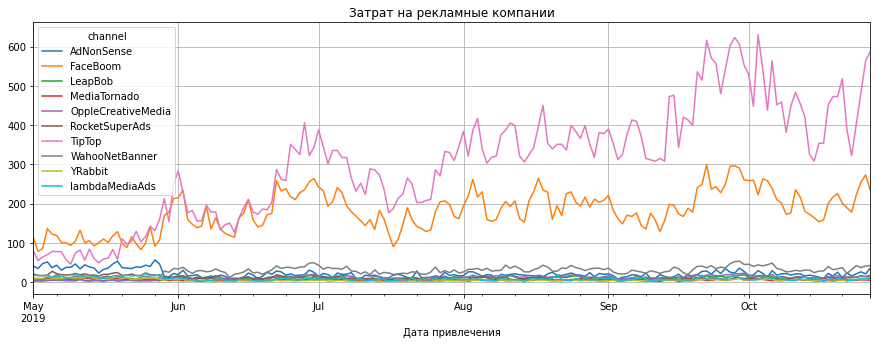

In [41]:
#Построим график изменения расходов во времени
costs_dt=costs
costs_dt['dt'] = pd.to_datetime(costs['dt'])
costs_dt.pivot_table(index='dt', columns='channel', values='costs').plot(grid=True, figsize=(15, 5))
plt.xlabel('Дата привлечения')
plt.title('Затрат на рекламные компании')
plt.show()

Видим что затраты на TipTop и FaceBoom до третей недели июня 2019 были почти одинаковые. После этой доты траты на TipTop начали расти а на FaceBoom остались на прежнем уровне.
По остальным каналам затраты на рекламу значительно ниже и стабильные 


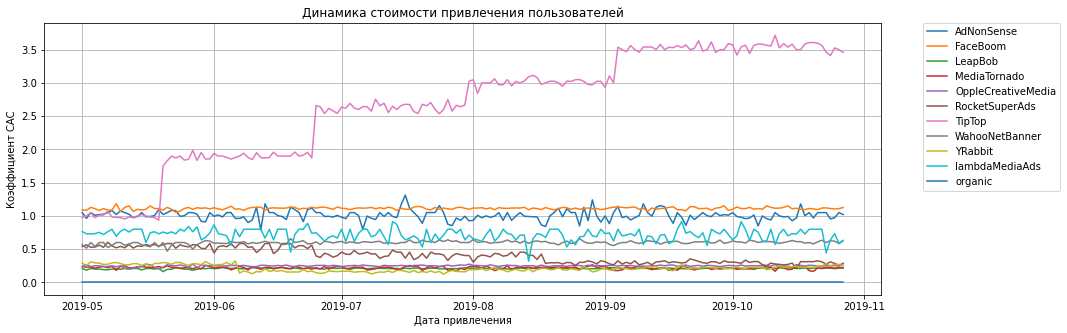

In [42]:
#Построим график динамики CAC для каждог канала привлецения

profiles.pivot_table(
            index='channel', columns='dt', values='acquisition_cost', aggfunc='mean'
        ).T.plot(grid=True, figsize=(15, 5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Дата привлечения')
plt.ylabel('Коэффициент CAC')
plt.title('Динамика стоимости привлечения пользователей')
plt.show()

In [43]:
#И выведем значения в табличном виде 
profiles.pivot_table(
            index='channel',  values='acquisition_cost',aggfunc='mean' )

,acquisition_cost
channel,
AdNonSense,1.008054
FaceBoom,1.113286
LeapBob,0.210172
MediaTornado,0.218717
OppleCreativeMedia,0.250000
RocketSuperAds,0.412095
TipTop,2.799003
WahooNetBanner,0.602245
YRabbit,0.218975


График показал нам что CAC для канала TipTop  скакнул до 1.5 в середине мая и после ещё было 2 скачка. В итоге в ноябре он составлял уже 3.5

FaceBoom бак же держится стабильно выше единицы
AdNonSense то больше по меньше единысы. 
По остальным каналам привлечения проблем нет, они постоянно ниже единицы 


Проведя анализ затрат на рекламу мы увидели что больше всего инвестиций приходится на каналы привлечения которые не окупаются TipTop и FaceBoom. Причём у TipTop САС составляет 3.5. то есть на каждую полученную единица дохода маркетинг тратит 3.5 ед 

### Оценим окупаемость рекламы

In [44]:
#Создадим переменную без органических пользователей и сохраним в переменную profiles_not_organic
profiles_not_organic=profiles[profiles['channel']!='organic']

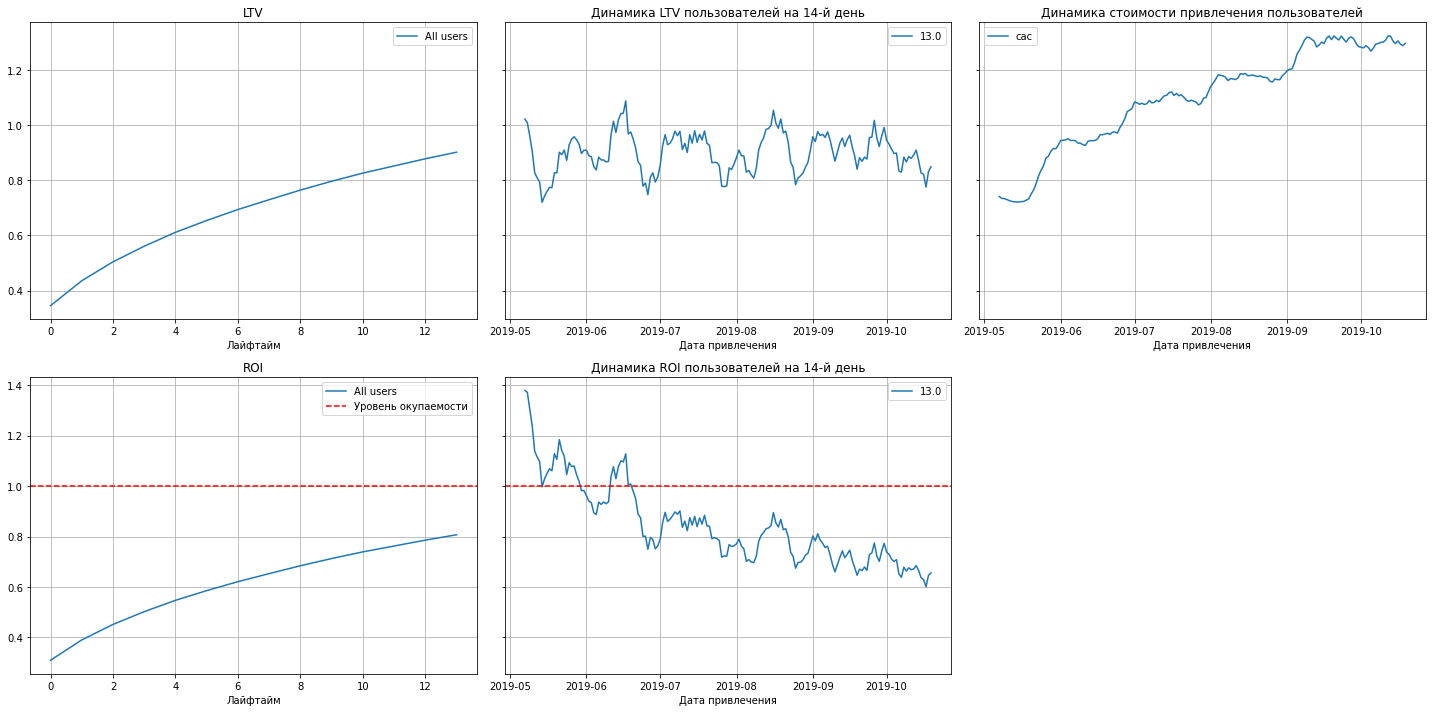

In [45]:
# Оценим общую ситуацию. 
# Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_not_organic, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 


Посмотрев на графики можес сделать несколько выводов. 

LTV показывает стабильный рост, как и должно. Сума денег, которую приносит клиент растёт
CAC совершает  скачки и стримится вверх что негативно сказывается на окупаемости рекламы 
Даже к 14му дню реклама не окупается, показатель ROI только немного переваливает через 80%


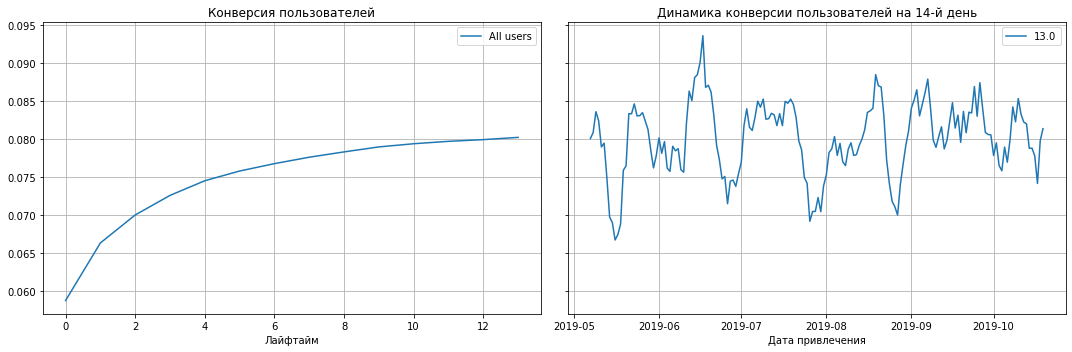

In [46]:
# смотрим конверсию пользователей

dimensions=[]
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_not_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графику общая конверсия по всем пользователям растёт до 6го дня, после чего рост начините замедляться 

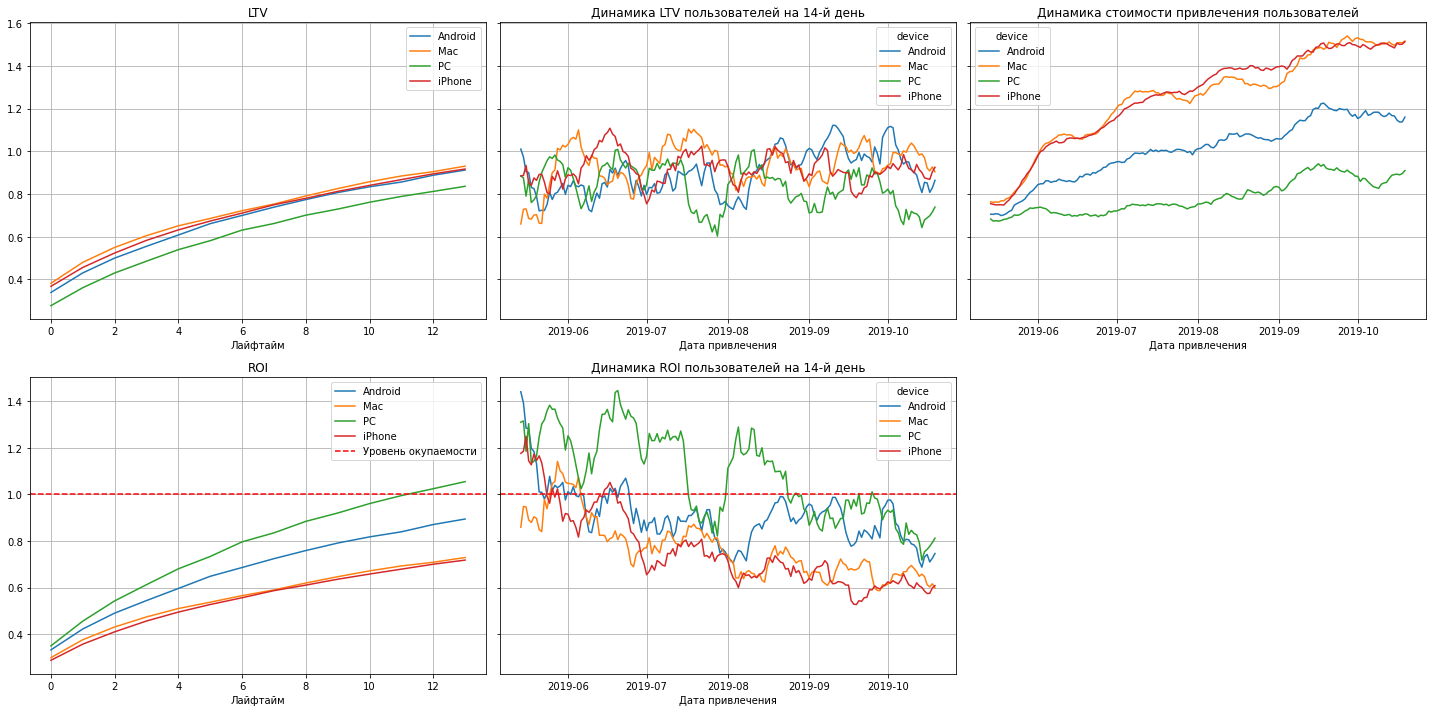

In [47]:
# смотрим окупаемость рекламы с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_not_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Судя по графику ROI на 11 день начинает окупаться реклама для ПК .  Для остальных не окупается вовсе
САС в свою очередь больше у айфонов и маков и почти одинаковый для них.  Стоимость привлечения для андроидов ниже. Самая низкая для ПК   

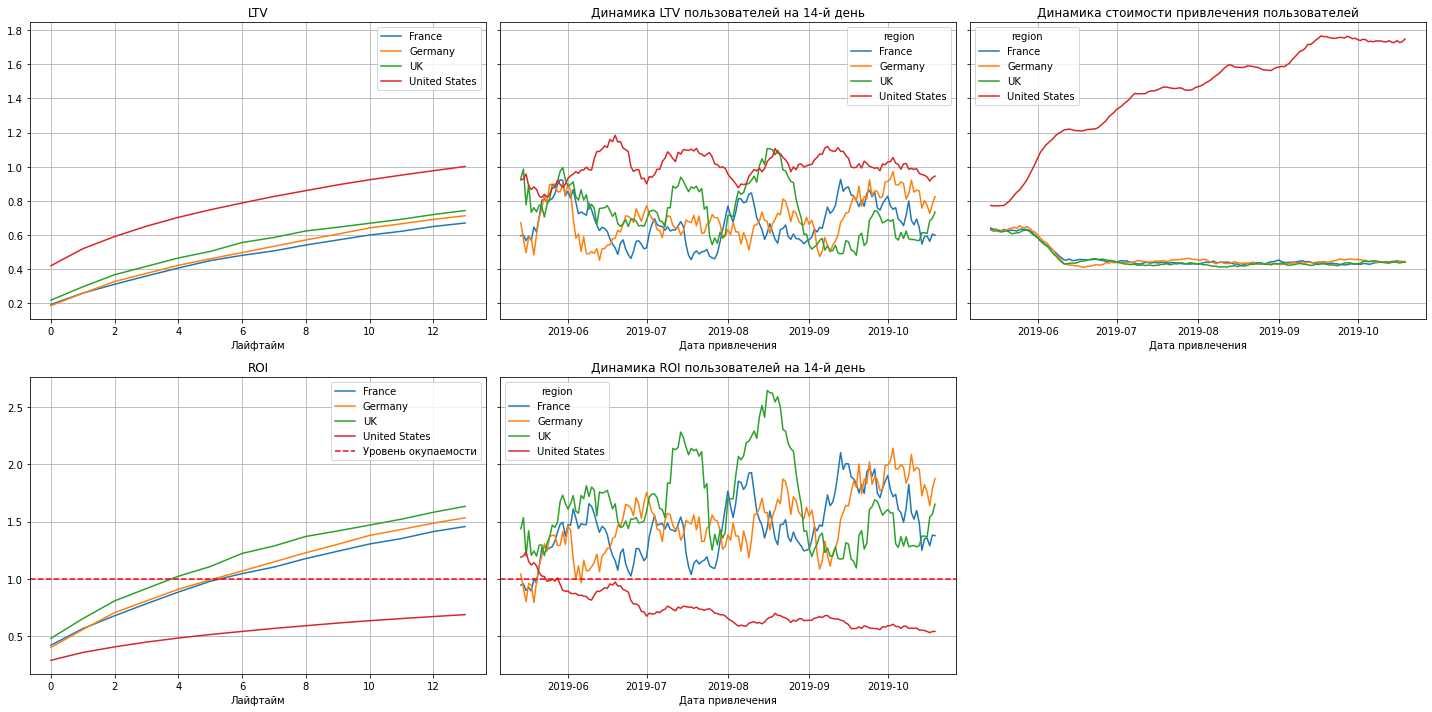

In [48]:
# смотрим окупаемость рекламы с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_not_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

САС для жителей Америки сально больше, и растёт. В остальных странах падает. 
При этом судя по графику ROI рекламные инвестиции не окупаются в отличии от всех других стран 

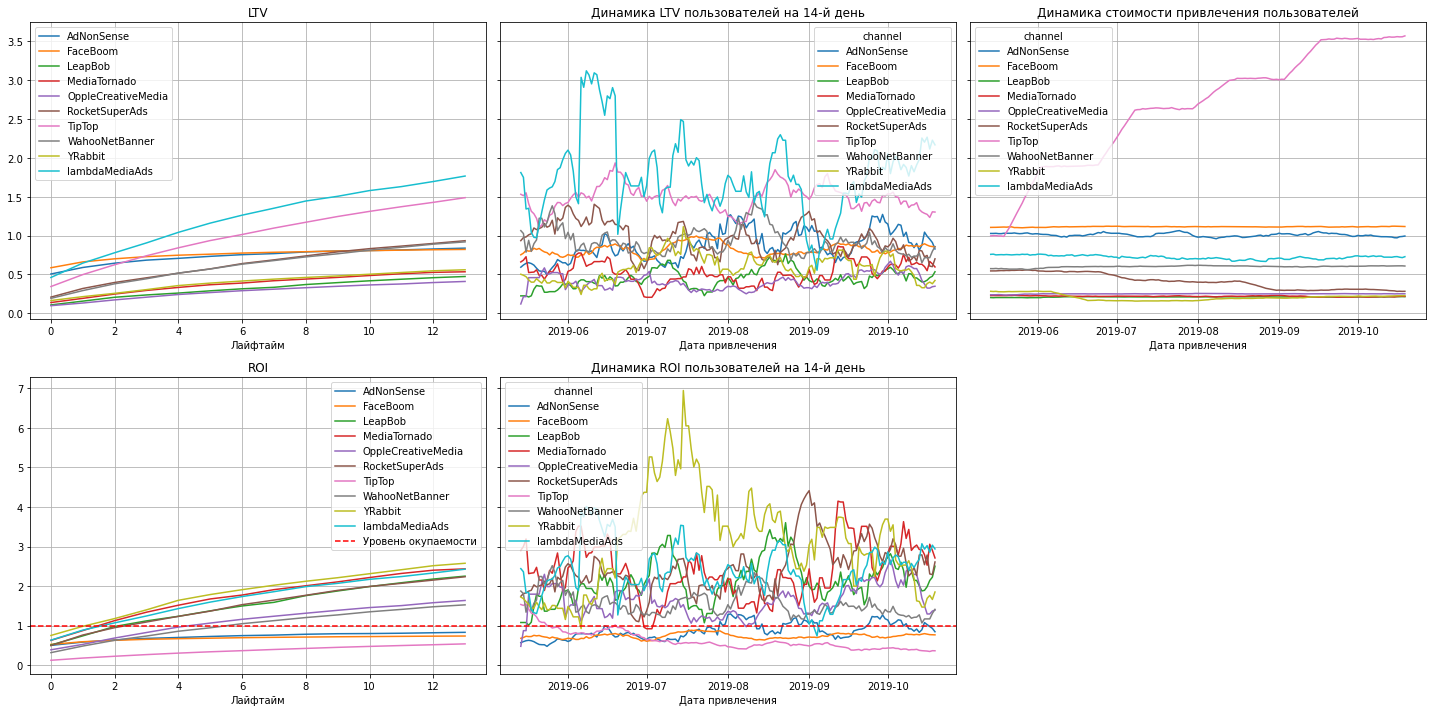

In [49]:
# смотрим окупаемость рекламы с разбивкой по рекламным каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_not_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 


Построим график повторно, но уберём «шумы» для удобства чтения графиков 

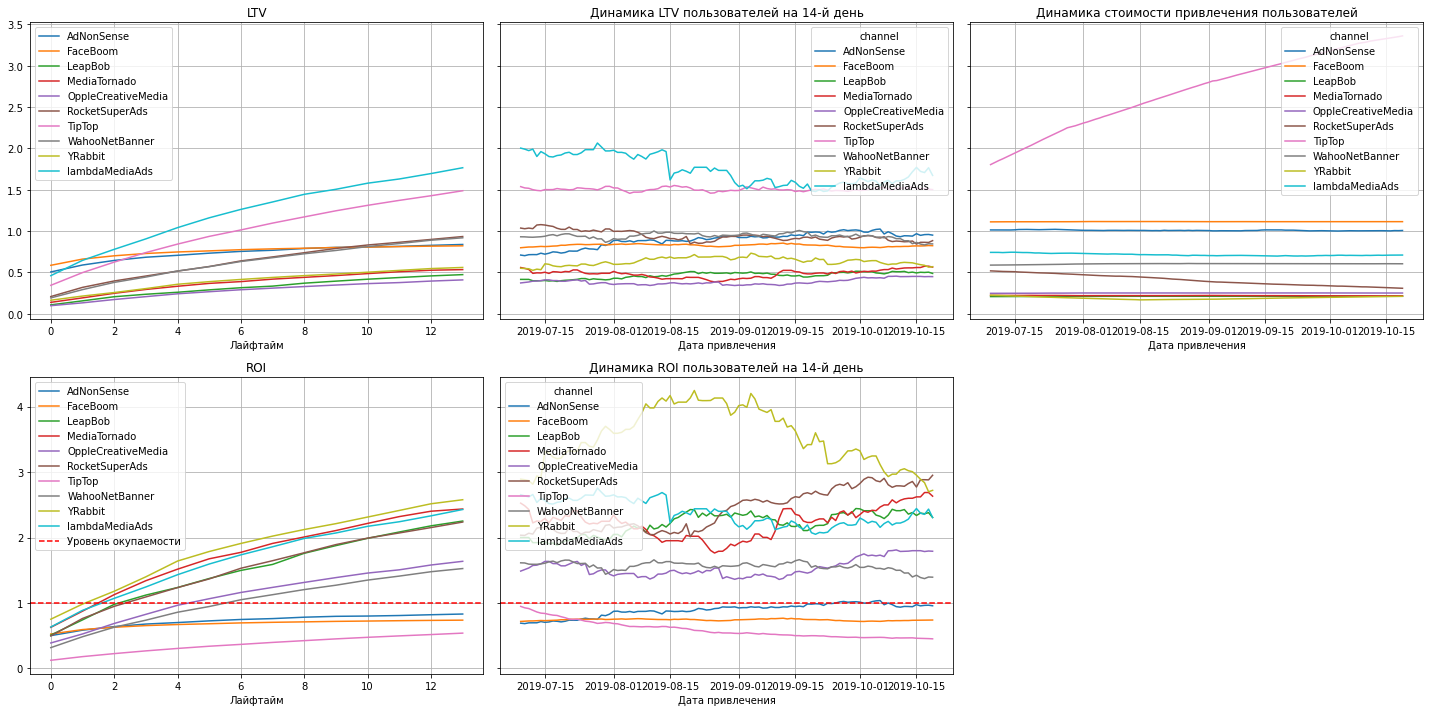

In [50]:
# смотрим окупаемость рекламы с разбивкой по рекламным каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_not_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, 
    window=70 #Значительно расширим шурину окна для того что бы сгладить графики 
) 


График ROI  подтвердил ранее полученную информацию о том что не окупаются каналы «TipTop», «FaceBoom» и «AdNonSense» привлечения при этом судя по графику CAC тратя на канал привлечения «TipTop» существенно больше трат на остальные каналы и продолжают расти 

Проанализировав данные можно сделать вывод что реклама на окупается за 14 дней заложенных в бизнес-плане.  Основное негативное влияние на общую окупаемость оказывают инвестиции в рекламу для жителей США (которые как мы знаем традиционно больше пользуются продукцией эйпл чем европейцы)  а так же канал привлечения «TipTop» на которые приходится большая часть рекламных трак и который показывает стабильно плохие показатели привлечения платящих пользователей 

Возможно нужно урезать инвестиции в канал привлечения «TipTop»

## Проверяем гипотезу

Посмотрим на показатели ROI и CAC  бед данных из каналов которые не окупаются  

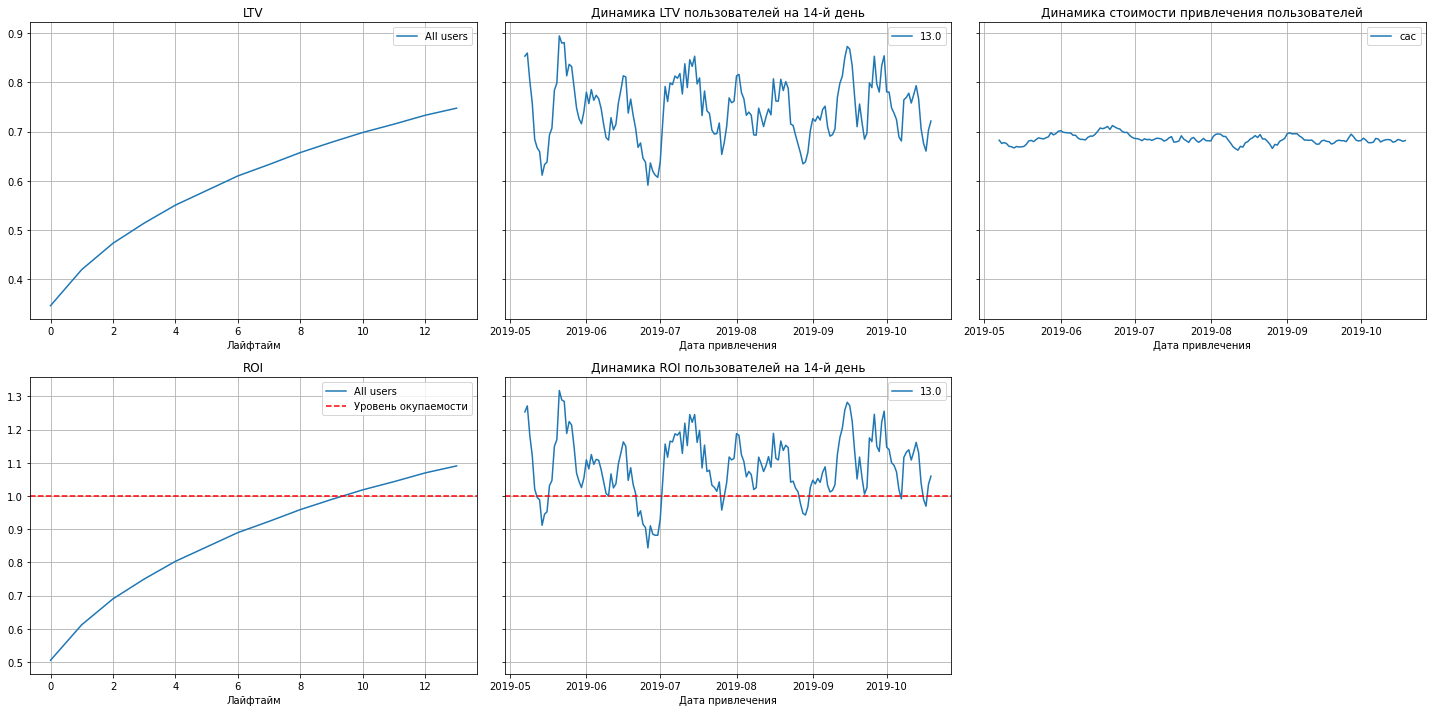

In [51]:
#Строим графики без «TipTop»  
profiles_not_TipTop = profiles_not_organic[profiles_not_organic['channel']!='TipTop']
user_id_notTipTop = profiles_not_TipTop['user_id'].unique()
orders_notTipTop = orders.query('user_id in @user_id_notTipTop')

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_not_TipTop, orders_notTipTop, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Если не учитывать данные связанные с каналом привлечения «TipTop»    общая окупаемость маркетинговых затрат приходится уже на 9 день

Проведём аналогичные расчёты для оставшихся 2х каналов привлечения которые вызывают у нас подозрения 

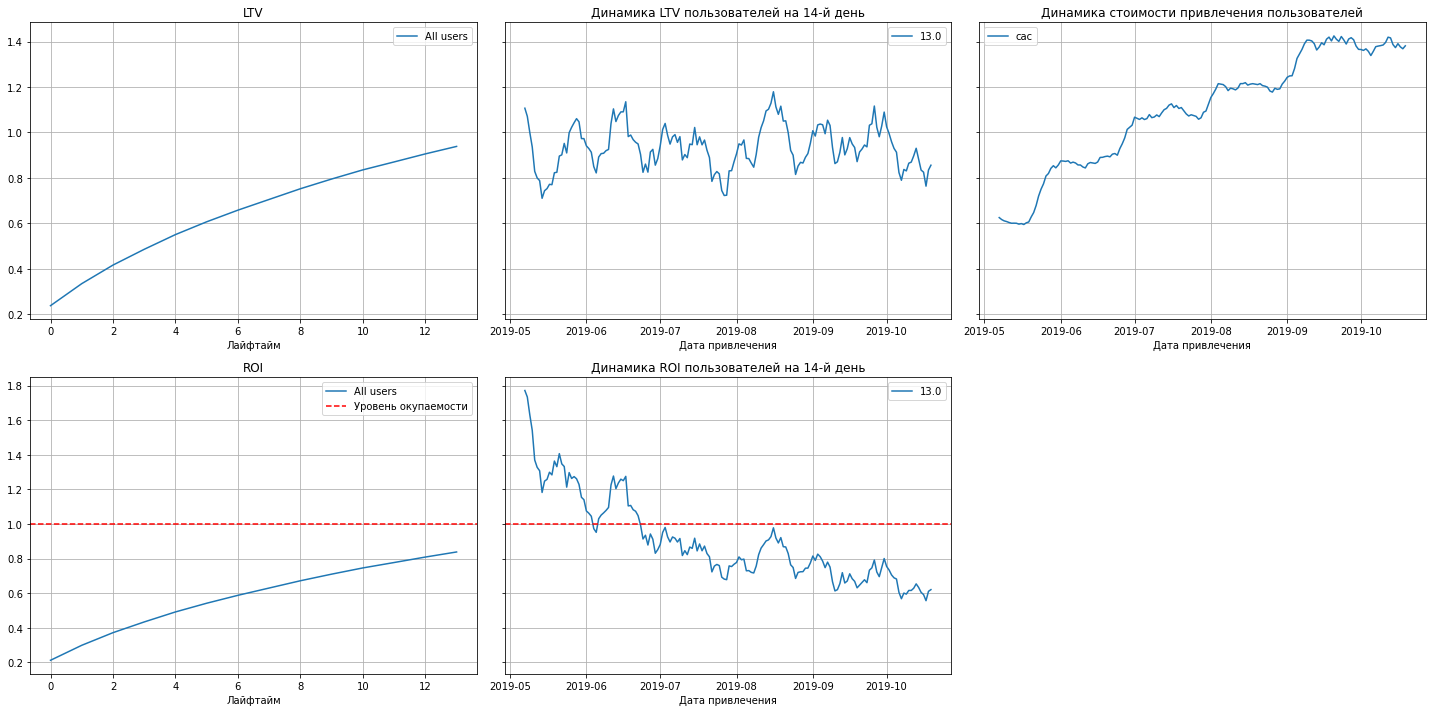

In [52]:
 
profiles_not_FaceBoom = profiles_not_organic[profiles_not_organic['channel']!='FaceBoom']
user_id_notFaceBoom = profiles_not_FaceBoom['user_id'].unique()
orders_notFaceBoom = orders.query('user_id in @user_id_notFaceBoom')

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_not_FaceBoom, orders_notFaceBoom, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Судя по графику ROI видим что без канала привлечения FaceBoom ситуация ухудшилась.



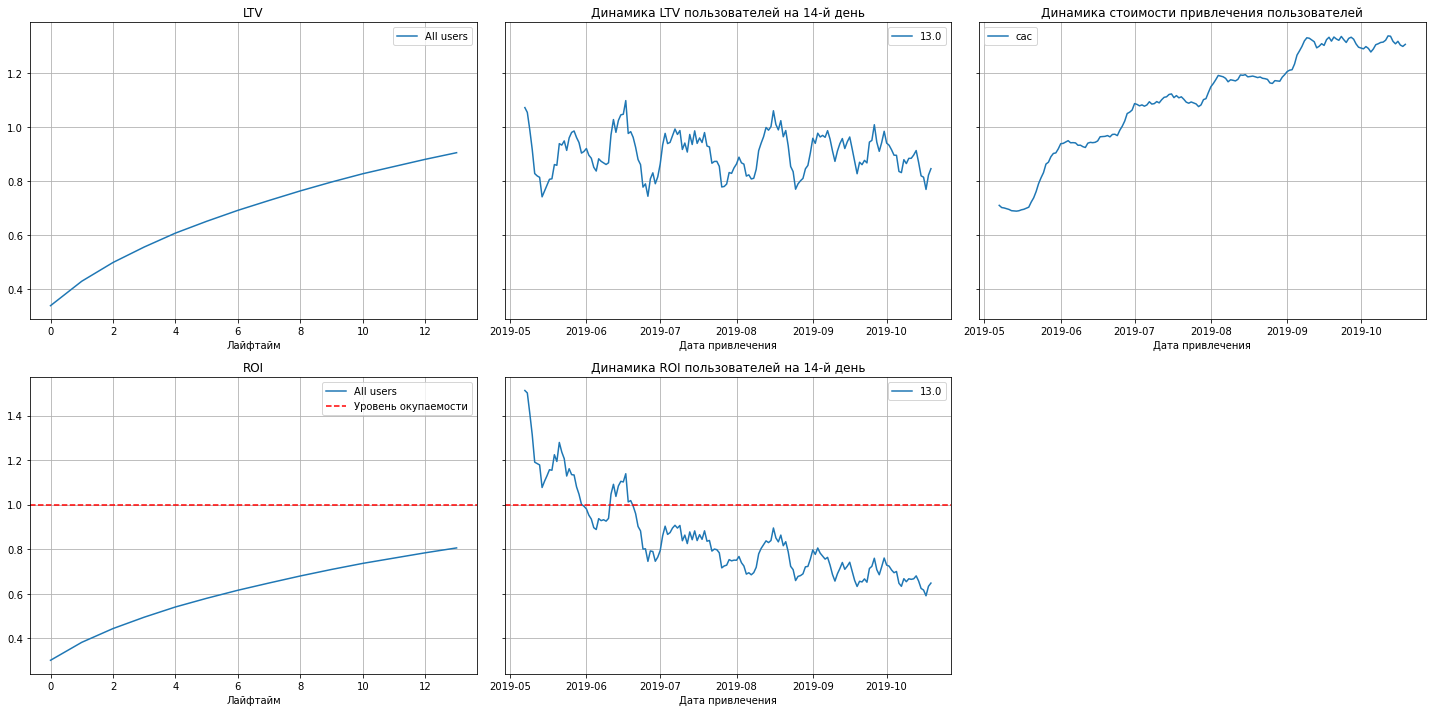

In [53]:
#Строим графики без «AdNonSense»  
profiles_not_AdNonSense= profiles_not_organic[profiles_not_organic['channel']!='AdNonSense']
user_id_notAdNonSense = profiles_not_AdNonSense['user_id'].unique()
orders_notAdNonSense = orders.query('user_id in @user_id_notAdNonSense')

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_not_AdNonSense, orders_notAdNonSense, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

С каналом «AdNonSense» ситуация аналогичная каналу «FaceBoom». 

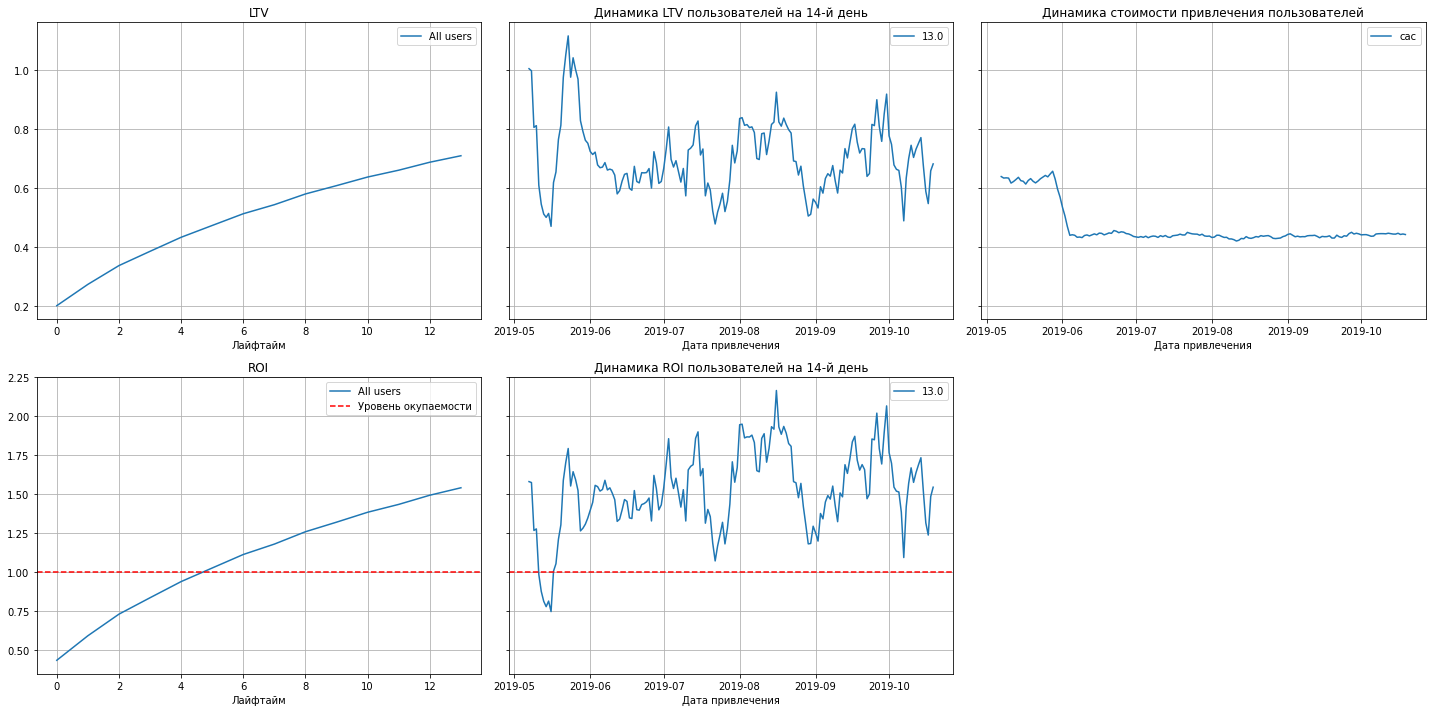

In [54]:
#Строим графики без пользователей из «США»  
profiles_not_usa= profiles_not_organic[profiles_not_organic['region']!='United States']
user_id_not_usa = profiles_not_usa['user_id'].unique()
orders_not_usa = orders.query('user_id in @user_id_not_usa')

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_not_usa, orders_not_usa, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

 График ROI  показывает что окупаемость рекламных вложений без пользователей из США произойдёт уже на 5й день и CAC выглядит стабильным 


Как видим убыточными являются пользователи из США и/или пользователи привлечённые через канал «TipTop» 

Посмотрим сколько всего пользователей в каждой из этих групп  


In [55]:
profiles_usa= profiles[profiles['region']=='United States'] #Создадим таблицу в которой будут только пользователи из Америки 
profiles_TipTop = profiles[profiles['channel']=='TipTop'] # И пользователи привлечённые через канал «TipTop»

In [56]:
print ('Всего пользователей',profiles['user_id'].count())
print()
print ('Всего пользователей из США', profiles_usa['user_id'].count(),
       'Процент от общего количества пользователей',
      (profiles_usa['user_id'].count()/profiles['user_id'].count()*100).round(),'%')
print()
print ('Всего пользователей привлечённых через канал «TipTop»', profiles_TipTop['user_id'].count(),
      'Процент от общего количества пользователей',
      (profiles_TipTop['user_id'].count()/profiles['user_id'].count()*100).round(),'%')

Всего пользователей 150008

Всего пользователей из США 100002 Процент от общего количества пользователей 67.0 %

Всего пользователей привлечённых через канал «TipTop» 19561 Процент от общего количества пользователей 13.0 %


Как видим пользователи из США составляют 67% всех пользователей
А вот пользователи привлечённые из канала TipTop только 13%


И посмотрим сколько всего платящих пользователей из США и/или пользователи привлечённые через канал «TipTop»

In [57]:

print ('Всего пользователей',profiles['user_id'][profiles.payer==1].count())
print()
print ('Всего пользователей из США', profiles_usa['user_id'][profiles_usa.payer==1].count(), 
       'Процент от общего количества пользователей',
      (profiles_usa['user_id'][profiles_usa.payer==1].count()/profiles['user_id'][profiles.payer==1].count()*100).round(),'%')
print()
print ('Всего пользователей привлечённых через канал «TipTop»', profiles_TipTop['user_id'][profiles_TipTop.payer==1].count(),
      'Процент от общего количества пользователей',
      (profiles_TipTop['user_id'][profiles_usa.payer==1].count()/profiles['user_id'][profiles.payer==1].count()*100).round(),'%')

Всего пользователей 8881

Всего пользователей из США 6902 Процент от общего количества пользователей 78.0 %

Всего пользователей привлечённых через канал «TipTop» 1878 Процент от общего количества пользователей 21.0 %


Платящие пользователи из США составляют 78% всех пользователей
Платящие пользователи привлечённые из канала TipTop только 21%

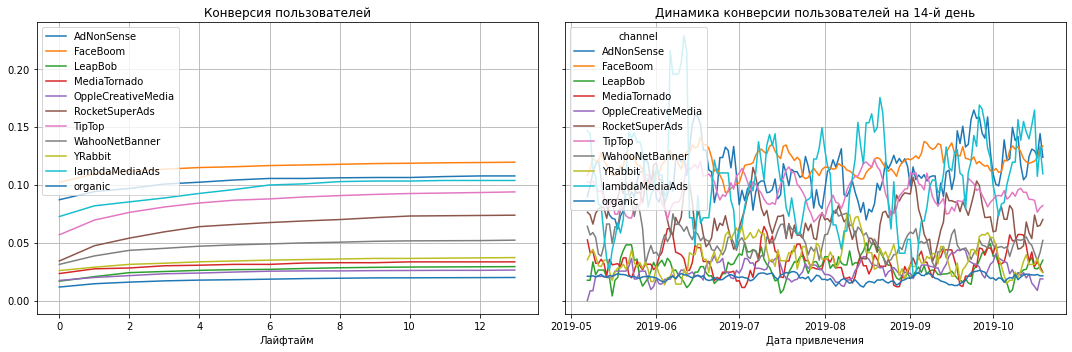

In [58]:
 #смотрим конверсию с разбивкой по каналам без учёта органических пользователей
dimensions = ['channel']    
    
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

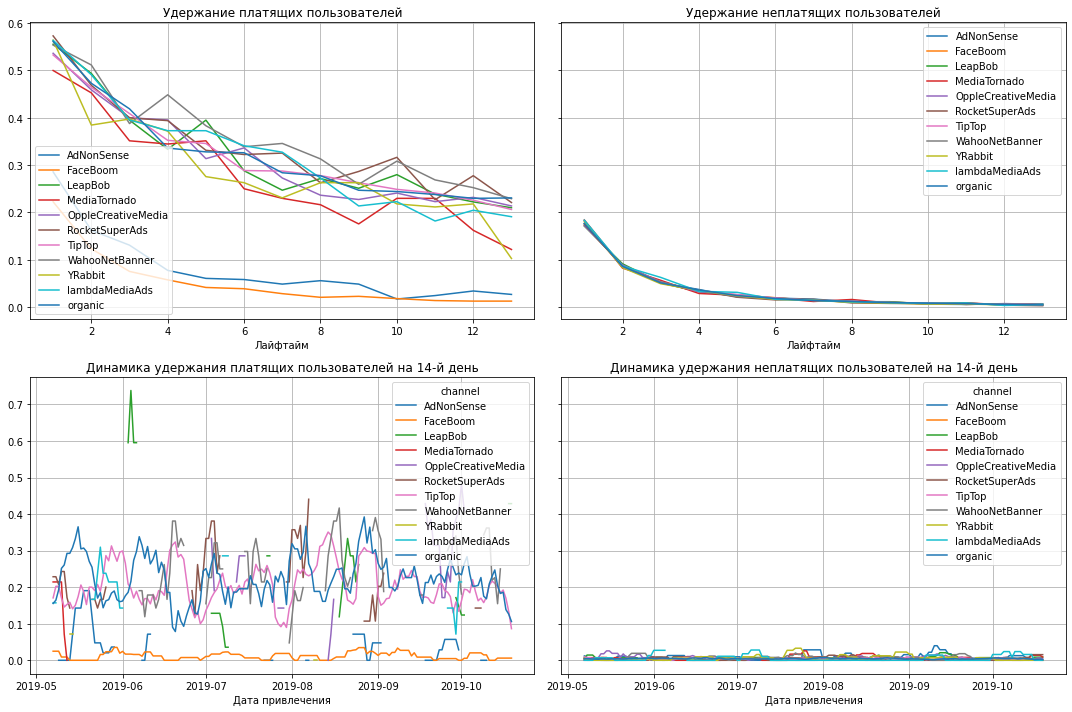

In [59]:
# смотрим удержание с разбивкой по каналам без учёта органических пользователей
dimensions = ['channel'] 

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Посмотрев на графики конверсии и удержания пользователей видим что канал TipTop на в лидерах по удержанию и по конверсии. Хуже всего с удержанием дела обстоят у FaceBoom и AdNonSense при хорошей конверсии

## Выводы

Проведя анализ инвестиции в рекламу за несколько месяцев, мы увидели, что больше всего инвестиций приходится на канал «TipTop». Он приносит 13% процентов общих пользователей и 21% платящих пользователи. Но в связи с тем, что этот канал финансируется больше всего, инвестиции в маркетинг не окупаются за 14 дней. Без этого канали окупаются уже на 9й день 

Есть проблемы с окупаемостью у каналов FaceBoom и AdNonSense. Скорее всего это связанно с низким уровнем удержания, очень большое и резкое падение уже на 3й день

Так же опасения вызывают пользователи из Америки если посчитать прибыль без них окупаемость инвестиций в маркетинг происходит уже на 5й день. 
Но они составляют большую часть платящих пользователей, 78% так что отказываться от них будет нецелесообразно



Возможно отделу маркетинга нужно ограничить инвестиции в канал привлечения «TipTop» который на данный момент медленно окупаемым и проработать возможность улучшения удержания для клиентов привлечённых с каналов FaceBoom и AdNonSense  
